In [1]:
### ATOC5860 - ATOC7500_applicationlab5_check_python_convolution
### Coded by Jennifer Kay and Elizabeth Maroon (University of Colorado)
### Last updated March 29, 2022

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import xarray
import pickle
print('finished...')

finished...


In [2]:
## Read in the data.
## Data are monthly Nino3.4 sea surface temperature (SST) time series (a proxy for ENSO) from the
## CESM Large Ensemble (http://www.cesm.ucar.edu/projects/community-projects/LENS/). 
## You will analyze pre-industrial control runs that represent perpetual 1850 conditions 
## (i.e., they have constant 1850 climate).
## Note: these are the same data from Homework #4 :) Remember???
## Data are munged (preprocessed) by the NCAR CVDP package
## http://www2.cesm.ucar.edu/working_groups/CVC/cvdp//data-repository.html

fname1 = "CESM1_LENS_Coupled_Control.cvdp_data.401-2200.nc"
ds1 = xarray.open_dataset(fname1,decode_times=False,decode_cf=False)
#ds1
data_fc = ds1["nino34"]
#print(data_fc)
nyrs=700
x = data_fc[0:12*nyrs]

## remove the mean (i.e., calculate the anomaly)
xa = x - np.mean(x)    

Shape of Original Data
(8400,)
Original Data - first three points
[-0.86 -1.03 -1.08]
Convolution by hand - first three points
[-0.29 -0.63 -0.99]
Convolution by hand - last three points
[-1.06 -0.75 -0.37]


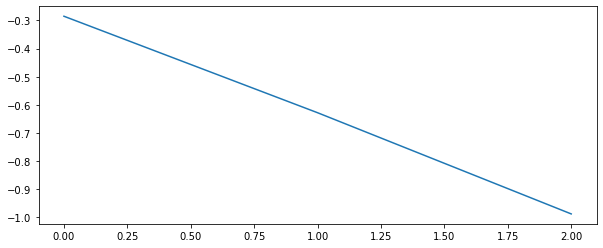

In [12]:
### What is under the hood with the python functions?  How are the edge effects treated?

## Let's see what is going on.  We'll do the convolution manually.
b = np.array([1,1,1])/3 ### a simple filter

print("Shape of Original Data")
print(np.shape(xa))

print("Original Data - first three points")
print(np.round(xa[0:3].values,2))
print("Convolution by hand - first three points")
by_hand_first3 = xa[0].values*1/3,\
                (xa[0].values*1+xa[1].values*1)/3,\
                (xa[0].values*1+xa[1].values*1+xa[2].values*1)/3
print(np.round(by_hand_first3,2))
print("Convolution by hand - last three points")
by_hand_last3 = (xa[-3].values*1+xa[-2].values*1+xa[-1].values*1)/3,(xa[-1].values*1+xa[-2].values*1)/3,xa[-1].values*1/3
print(np.round(by_hand_last3,2))


fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(by_hand_first3)

Convolution by np.convolve - first three points
[-0.29 -0.63 -0.99]
Convolution by np.convolve - last three points
[-1.06 -0.75 -0.37]
shape of array resulting from np.convolve
(8402,)

Convolution by np.convolve 'full' - first three points
[-0.29 -0.63 -0.99]
Convolution by np.convolve 'full' - last three points
[-1.06 -0.75 -0.37]
shape of array resulting from np.convolve 'full'
(8402,)

Convolution by np.convolve 'same' - first three points
[-0.63 -0.99 -1.02]
Convolution by np.convolve 'same' - last three points
[-0.88 -1.06 -0.75]
shape of array resulting from np.convolve 'same'
(8400,)

Convolution by np.convolve 'valid' - first three points
[-0.99 -1.02 -0.95]
Convolution by np.convolve 'valid' - last three points
[-0.6  -0.88 -1.06]
shape of array resulting from np.convolve 'valid'
(8398,)


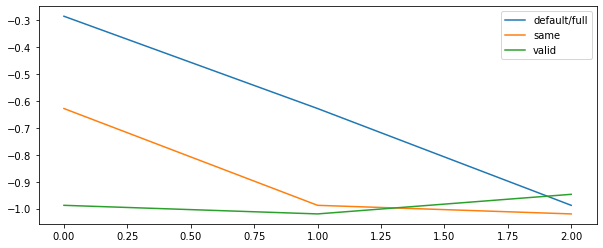

In [13]:
## what does np.convolve do??  lots of different things :).
fig,ax = plt.subplots(1,1,figsize=(10,4))

## mode = 'full' is the default
y2 = np.convolve(xa,b)
print("Convolution by np.convolve - first three points")
print(np.round(y2[0:3],2))
print("Convolution by np.convolve - last three points")
print(np.round(y2[-3:],2))
print("shape of array resulting from np.convolve")
print(np.shape(y2))
print()

## 'full' starts with the first value and add points at the end - matches calculation by hand at both start and end
## This returns the convolution at each point of overlap, with an output shape of (N+M-1,). 
## At the end-points of the convolution, the signals do not overlap completely, and boundary effects may be seen.
y3 = np.convolve(xa,b,'full')
print("Convolution by np.convolve 'full' - first three points")
print(np.round(y3[0:3],2))
print("Convolution by np.convolve 'full' - last three points")
print(np.round(y3[-3:],2))
print("shape of array resulting from np.convolve 'full'")
print(np.shape(y3))
print()
ax.plot(y3[0:3], label='default/full')

## 'same' 
## Mode ‘same’ returns output of length max(M, N). Boundary effects are still visible.
y4 = np.convolve(xa,b,'same')
print("Convolution by np.convolve 'same' - first three points")
print(np.round(y4[0:3],2))
print("Convolution by np.convolve 'same' - last three points")
print(np.round(y4[-3:],2))
print("shape of array resulting from np.convolve 'same'")
print(np.shape(y4))
print()
ax.plot(y4[0:3], label='same')

## 'valid' 
## Mode ‘valid’ returns output of length max(M, N) - min(M, N) + 1. 
##The convolution product is only given for points where the signals overlap completely. 
##Values outside the signal boundary have no effect.
y5 = np.convolve(xa,b,'valid')
print("Convolution by np.convolve 'valid' - first three points")
print(np.round(y5[0:3],2))
print("Convolution by np.convolve 'valid' - last three points")
print(np.round(y5[-3:],2))
print("shape of array resulting from np.convolve 'valid'")
print(np.shape(y5))
ax.plot(y5[0:3], label='valid')
plt.legend()



Filtering using lfilter - first three points
[-0.29 -0.63 -0.99]
Filtering using lfilter - last three points (it is ignoring last two points)
[-0.6  -0.88 -1.06]
shape of array resulting from sig.lfilter
(8400,)


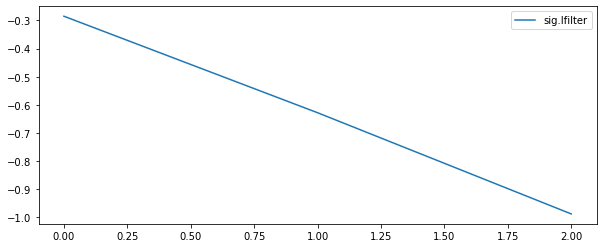

In [10]:
## what does sig.lfilter do?  
## it uses np.convolve so it also starts with the first value, but cuts off the last value (at the end)
## Source code here: https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L1719-L1909
yfilt = sig.lfilter(b,1,xa)
print("Filtering using lfilter - first three points")
print(np.round(yfilt[0:3],2))
print("Filtering using lfilter - last three points (it is ignoring last two points)")
print(np.round(yfilt[-3:],2))
print("shape of array resulting from sig.lfilter")
print(np.shape(yfilt))

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(yfilt[0:3], label='sig.lfilter')
plt.legend()

Filtering using filtfilt
[-0.86 -0.95 -0.98]
shape of array resulting from sig.lfilter
(8400,)


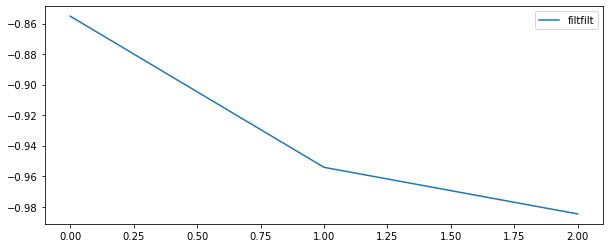

In [14]:
## what does sig.filtfilt do?  
## apply the filter forward - cut it off second to last 
## apply the filter backward - cut if off second to last (in other words the first point)
## going each way -- you get to filter the edges from both directions at least once.
## filtering using filtfilt makes the most of the data at the edges
## filtfilt makes the most of all of your data... so it's a good choice to use
## Look at the original python code -- filtfilt is applying lfilt twice
##https://github.com/scipy/scipy/blob/v0.18.1/scipy/signal/signaltools.py#L858-L1041

## Notes on padding:
# When method is “pad”, the function pads the data along the given axis in one of three ways: odd, even or constant. 
# The odd and even extensions have the corresponding symmetry about the end point of the data. 
# The constant extension extends the data with the values at the end points. 
# On both the forward and backward passes, the initial condition of the filter 
# is found by using lfilter_zi and scaling it by the end point of the extended data.
# When method is “gust”, Gustafsson’s method [1] is used. Initial conditions are chosen for the 
# forward and backward passes so that the forward-backward filter gives the same result 
# as the backward-forward filter.

yfiltfilt=sig.filtfilt(b,1,xa)
print("Filtering using filtfilt")
print(np.round(yfiltfilt[0:3],2))
print("shape of array resulting from sig.lfilter")
print(np.shape(yfiltfilt))

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(yfiltfilt[0:3], label='filtfilt')
plt.legend()

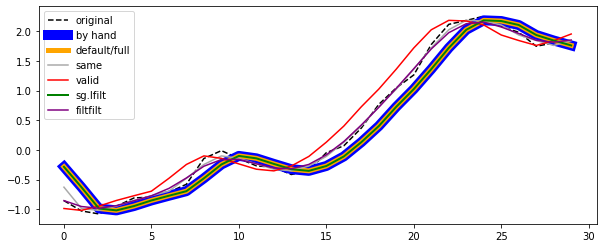

In [24]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(by_hand_first3)
ax.plot(xa[0:30], c='black', ls='--', label='original')
ax.plot(y2[0:30], c='blue',lw=10,label='by hand')
ax.plot(y3[0:30], c='orange', lw=5,label='default/full')
ax.plot(y4[0:30], c='darkgray', label='same')
ax.plot(y5[0:30], c='red',label='valid')
ax.plot(yfilt[0:30], c='green',lw=2, label='sg.lfilt')
ax.plot(yfiltfilt[0:30], c='purple',label='filtfilt')

plt.legend()